In [386]:
from comp_math import AutoDiffNum

import numpy as np
import matplotlib.pyplot as plt

In [387]:
def progonka(mat: np.matrix, vals: np.array):
    n = len(vals)

    a = [-mat[0, 1] / mat[0, 0]]
    b = [vals[0] / mat[0, 0]]

    for i in range(1, n):
        y = mat[i, i] + mat[i, i - 1] * a[-1]

        if i < n - 1:
            a.append(- mat[i, i + 1] / y)
        b.append((vals[i] - mat[i, i - 1] * b[-1]) / y)

    res = [b[-1]]
    for i in range(n - 2, -1, -1):
        res.append(a[i] * res[-1] + b[i])

    return np.array(res)[::-1]

In [388]:
def splain_3_interpolant(x_nodes, y_nodes):
    n = len(x_nodes) - 1

    a = y_nodes

    h = [x_nodes[i + 1] - x_nodes[i] for i in range(n)]

    mat = np.matrix(
        [([1.] + [0.] * n)] +

        [[0.] * (i - 1) +
         [h[i - 1]] + [2 * (h[i] + h[i - 1])] + [h[i]] +
         [0.] * (n - i - 1) for i in range(1, n)] +

        [([0.] * n + [1.])]
    )

    vals = np.array([0.] +
                    [3 / h[i] * (a[i + 1] - a[i]) - 3 / h[i - 1] * (a[i] - a[i - 1]) for i in
                     range(1, n)] +
                    [0.])

    c = progonka(mat, vals)

    b = []
    for i in range(n):
        b.append(1 / h[i] * (a[i + 1] - a[i]) - h[i] / 3 * (c[i + 1] + 2 * c[i]))

    d = []
    for i in range(n):
        d.append((c[i + 1] - c[i]) / (3 * h[i]))
        
        
    coeff_mat = np.matrix([[a[i], b[i], c[i], d[i]] for i in range(n)])
    return coeff_mat

In [389]:
def get_interpolant_points(x_points, x_nodes, coeff_mat):
    n = len(x_nodes) - 1    
    
    a = np.array(coeff_mat[:, 0])
    b = np.array(coeff_mat[:, 1])
    c = np.array(coeff_mat[:, 2])
    d = np.array(coeff_mat[:, 3])
    
    y_points = []
    for x in x_points:
        for i in range(n):
            if x_nodes[i] <= x <= x_nodes[i + 1]:
                y_points.append((a[i] + b[i] * (x - x_nodes[i]) + c[i] * (x - x_nodes[i]) ** 2 + d[i] * (x - x_nodes[i]) ** 3)[0])
                break

    return y_points

In [390]:
def get_points_from_file(filename: str):
    f = open(filename, 'r')
    points = list(map(lambda x: tuple(map(float, x.split(' '))), f.readlines()))
    f.close()
    
    return points

In [391]:
def put_coeffs_to_file(filename: str, flag: str, coeff_mat_x, coeff_mat_y):
    f = open(filename, flag)
    
    for coeffs in zip(coeff_mat_x.tolist(), coeff_mat_y.tolist()):
        coeffs_1_2 = list(coeffs[0]) + list(coeffs[1])
        f.write(str(coeffs_1_2).strip("[]") + '\n')
        
    f.close()

In [392]:
def lab1_base(filename_in: str, factor:int, filename_out:str):
    points = get_points_from_file(filename_in)
    n = len(points)

    x_nodes = [points[i][0] for i in range(0, n, factor)]
    y_nodes = [points[i][1] for i in range(0, n, factor)]
    
    n = len(x_nodes)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    ax.plot(x_nodes, y_nodes, 'ro', markersize=10)

    t = [i for i in range(n)]
    coeff_mat_x = splain_3_interpolant(t, x_nodes)
    coeff_mat_y = splain_3_interpolant(t, y_nodes)
    
    t_for_plotting = np.arange(0, n - 1 + 0.1, 0.1)
    x_points = get_interpolant_points(t_for_plotting, t, coeff_mat_x)
    y_points = get_interpolant_points(t_for_plotting, t, coeff_mat_y)
    
    print([np.sqrt((x_points[i] - points[i][0])**2 + (y_points[i] - points[i][1])**2) for i in range(len(x_points))])

    ax.plot(x_points, y_points, 'g-', linewidth=4)
    ax.grid()
    
    x_ampl = max(x_points) - min(x_points)
    y_ampl = max(y_points) - min(y_points)
    derivative_vector_length = min(x_ampl, y_ampl) / 10
    
    t_for_derivative = np.linspace(0, n - 1, 5)
    x_d_points = AutoDiffNum.G(t_for_derivative, t, coeff_mat_x)
    y_d_points = AutoDiffNum.G(t_for_derivative, t, coeff_mat_y)

    for i in range(len(t_for_derivative)):
        x_point = get_interpolant_points([t_for_derivative[i]], t, coeff_mat_x)
        y_point = get_interpolant_points([t_for_derivative[i]], t, coeff_mat_y)
        
        start_point = (x_point[0], y_point[0])
        
        vector_length= np.sqrt(x_d_points[i] ** 2 + y_d_points[i] ** 2)
        d_vector = (x_d_points[i], y_d_points[i]) / vector_length * derivative_vector_length
        d_end_point = (start_point[0] + d_vector[0], start_point[1] + d_vector[1])
        
        n_vector = AutoDiffNum.R(d_vector)
        n_end_point = (start_point[0] + n_vector[0], start_point[1] + n_vector[1])
        
        ax.plot([start_point[0]], [start_point[1]], 'bo', markersize=10)
        
        ax.plot([start_point[0], d_end_point[0]], [start_point[1], d_end_point[1]], 'b-', linewidth=2)
        
        ax.plot([start_point[0], n_end_point[0]], [start_point[1], n_end_point[1]], 'b-', linewidth=2)
    
    put_coeffs_to_file(filename_out, 'w', coeff_mat_x, coeff_mat_y)


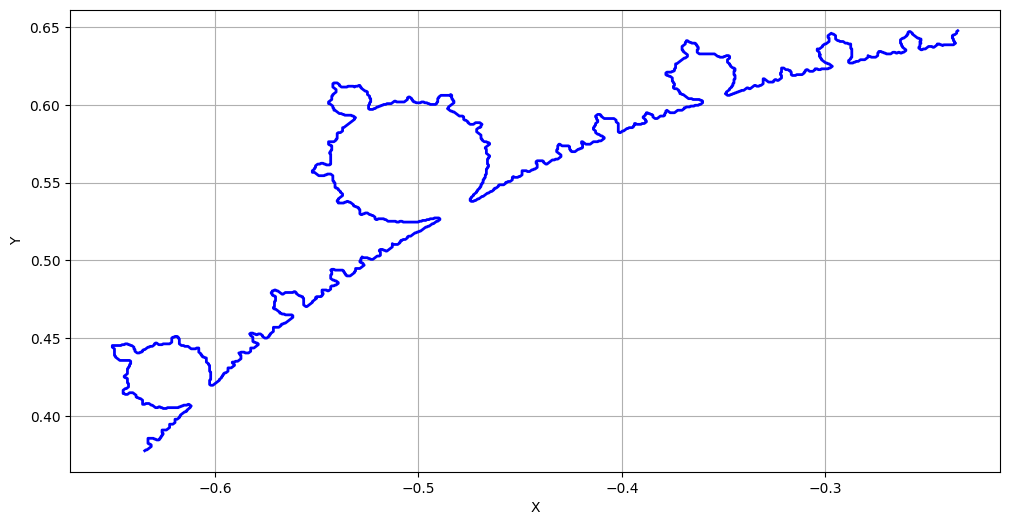

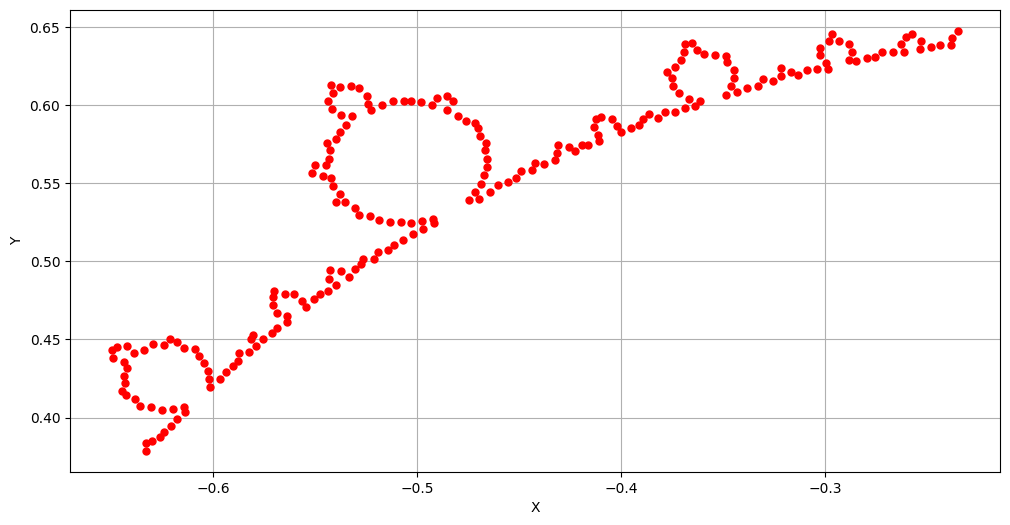

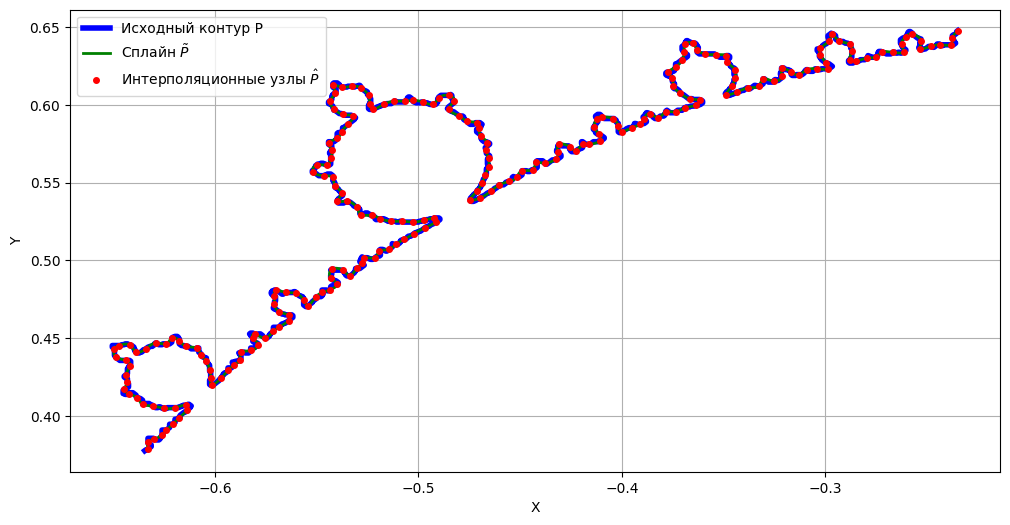

0.000584274204086712
0.00044253443909155827


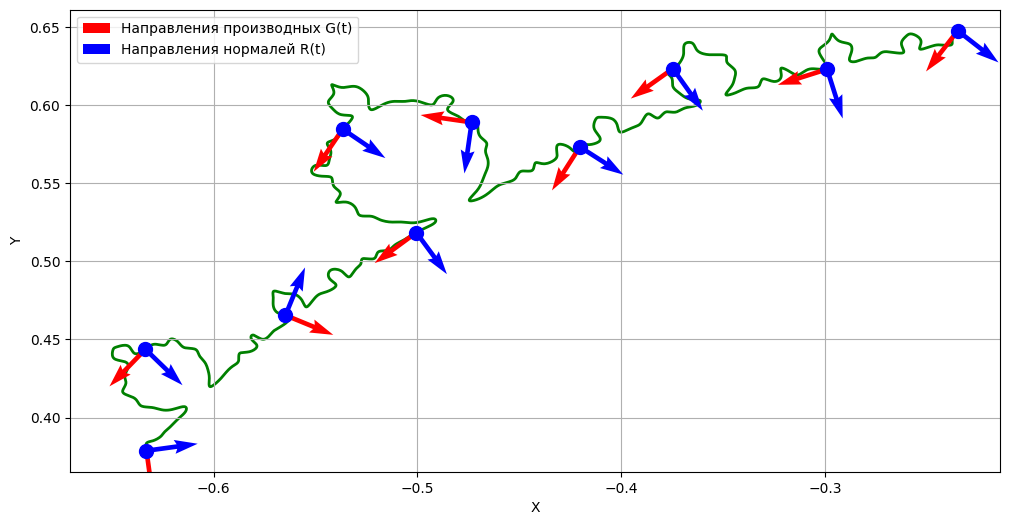

In [393]:
lab1_base('contour.txt', 10, 'output.txt')